## Setup

In [2]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import datetime

import functools
import IPython
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


import glucose_ts

# plot layouts
sns.set_style("whitegrid")
sns.set_context(
    "notebook",
    rc={
        "axes.titlesize": 36,
        "axes.labelsize": 32,
        "lines.linewidth": 5,
        "lines.markersize": 24,
        "xtick.labelsize": 32,
        "ytick.labelsize": 32,
        'legend.fontsize': 24,
        'figsize': (15, 15),
    }
)
sns.color_palette("dark")

plt.subplots_adjust(wspace=1.5)
DATA_DIR = os.path.join(os.path.dirname(os.path.dirname(glucose_ts.__file__)), 'data')

FIG_DIR = os.path.join(
    os.path.dirname(os.path.dirname(glucose_ts.__file__)),
    'presentations',
    'results_outline',
    'images'
)


<Figure size 432x288 with 0 Axes>

# Calibration in Medium

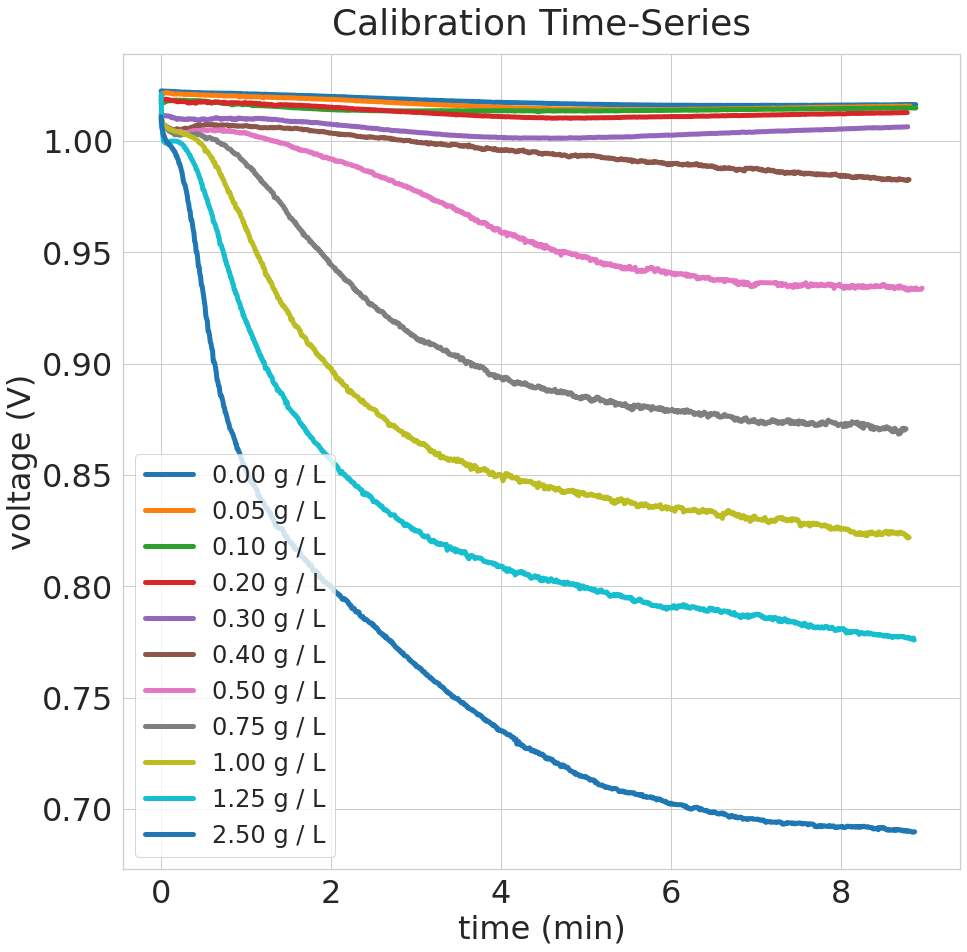

In [11]:
max_time = (20, 15)
base_path = os.path.join(DATA_DIR, 'warm_standards_hamilton')

callibration_paths = [
    os.path.join(base_path, one)
    for one in tuple(os.walk(base_path))[0][2]
    if tuple([
        int(number) 
        for number in one.split('__')[1].split('_')[:2]
    ]) < max_time
]


calibration_curves = sorted(
    [
        glucose_ts.data.read_glucose_ts(path)
        for path in callibration_paths
    ],
    key=lambda one: one.real_concentration
)

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

for one_curve in calibration_curves:
    
    ax.plot(
        one_curve.points_in_time,
        one_curve.voltages,
        label='%3.2f g / L' % one_curve.real_concentration,
    )

ax.set_xlabel('time (min)')
ax.set_ylabel('voltage (V)')

ax.set_title('Calibration Time-Series', pad=20)
ax.legend()

fig.savefig(
    os.path.join(
        FIG_DIR,
        'calibration_time_series.png'
    ),
    transparent=True,
)


In [13]:
all_paths = [
    os.path.join(prefix, file)
    for prefix, _, files in os.walk(DATA_DIR)
    for file in files
]

unlabeled_curves = [
    glucose_ts.data.read_glucose_ts(path)
    for path in set(all_paths) - set(callibration_paths)
]
len(unlabeled_curves)


74

In [26]:
CUT_OFF_IDX = 200
CLUSTER_LENGTH = 10


val_predictions_and_labels = glucose_ts.evaluation.both_models.cross_validation_both_models(
    labeled_ts=calibration_curves,
    unlabeled_ts=unlabeled_curves,
    num_folds=3,
    voltage_model_fn=functools.partial(
        glucose_ts.models.lstm.train_lstm_voltage_model,
        cluster_cut_off_idx=int(CUT_OFF_IDX / CLUSTER_LENGTH),
        batch_size=64,
        units=16,
        lstm_regularization=5e-9,
        dense_regularization=1e-8,
        lstm_dropout=0.,
        dense_layer_sizes=(10, 5),
        learning_rate=1e-4,
        num_epochs=100,
        patience=20,
        shuffle_buffer=1000,
        steps_per_epoch=500,
        cluster_length=CLUSTER_LENGTH,
    ),
    glucose_model_fn=functools.partial(
        glucose_ts.models.exponential_decay.get_glucose_model,
        avg_start_idx=35,
        cluster_length=CLUSTER_LENGTH,

    ),
    cut_off_idx=CUT_OFF_IDX,
)


Epoch 1/100
500/500 [==============================] - 74s 47ms/step - loss: 0.5994 - val_loss: 0.3082
Epoch 2/100
500/500 [==============================] - 24s 48ms/step - loss: 0.1299 - val_loss: 0.0795
Epoch 3/100
500/500 [==============================] - 23s 45ms/step - loss: 0.0649 - val_loss: 0.0688
Epoch 4/100
500/500 [==============================] - 22s 44ms/step - loss: 0.0575 - val_loss: 0.0550
Epoch 5/100
500/500 [==============================] - 27s 55ms/step - loss: 0.0544 - val_loss: 0.0559
Epoch 6/100
500/500 [==============================] - 24s 47ms/step - loss: 0.0512 - val_loss: 0.0526
Epoch 7/100
500/500 [==============================] - 22s 44ms/step - loss: 0.0468 - val_loss: 0.0495
Epoch 8/100
500/500 [==============================] - 23s 46ms/step - loss: 0.0427 - val_loss: 0.0451
Epoch 9/100
500/500 [==============================] - 23s 47ms/step - loss: 0.0401 - val_loss: 0.0442
Epoch 10/100
500/500 [==============================] - 27s 53ms/step - l

Epoch 40/100
500/500 [==============================] - 22s 44ms/step - loss: 0.0200 - val_loss: 0.0466
Epoch 41/100
500/500 [==============================] - 22s 44ms/step - loss: 0.0193 - val_loss: 0.0471
Epoch 42/100
500/500 [==============================] - 22s 44ms/step - loss: 0.0194 - val_loss: 0.0462
Epoch 43/100
500/500 [==============================] - 22s 44ms/step - loss: 0.0193 - val_loss: 0.0463
Epoch 44/100
500/500 [==============================] - 25s 51ms/step - loss: 0.0192 - val_loss: 0.0462
Epoch 45/100
500/500 [==============================] - 23s 46ms/step - loss: 0.0191 - val_loss: 0.0446
Epoch 46/100
500/500 [==============================] - 23s 47ms/step - loss: 0.0195 - val_loss: 0.0418
Epoch 47/100
500/500 [==============================] - 22s 44ms/step - loss: 0.0189 - val_loss: 0.0430
Epoch 48/100
500/500 [==============================] - 22s 44ms/step - loss: 0.0190 - val_loss: 0.0425
Epoch 49/100
500/500 [==============================] - 23s 47ms

Epoch 19/100
500/500 [==============================] - 22s 43ms/step - loss: 0.0263 - val_loss: 0.0206
Epoch 20/100
500/500 [==============================] - 22s 44ms/step - loss: 0.0262 - val_loss: 0.0214
Epoch 21/100
500/500 [==============================] - 22s 43ms/step - loss: 0.0262 - val_loss: 0.0195
Epoch 22/100
500/500 [==============================] - 22s 44ms/step - loss: 0.0256 - val_loss: 0.0163
Epoch 23/100
500/500 [==============================] - 25s 50ms/step - loss: 0.0260 - val_loss: 0.0203
Epoch 24/100
500/500 [==============================] - 25s 51ms/step - loss: 0.0256 - val_loss: 0.0157
Epoch 25/100
500/500 [==============================] - 23s 47ms/step - loss: 0.0256 - val_loss: 0.0161
Epoch 26/100
500/500 [==============================] - 21s 42ms/step - loss: 0.0254 - val_loss: 0.0119
Epoch 27/100
500/500 [==============================] - 22s 44ms/step - loss: 0.0255 - val_loss: 0.0147
Epoch 28/100
500/500 [==============================] - 22s 44ms

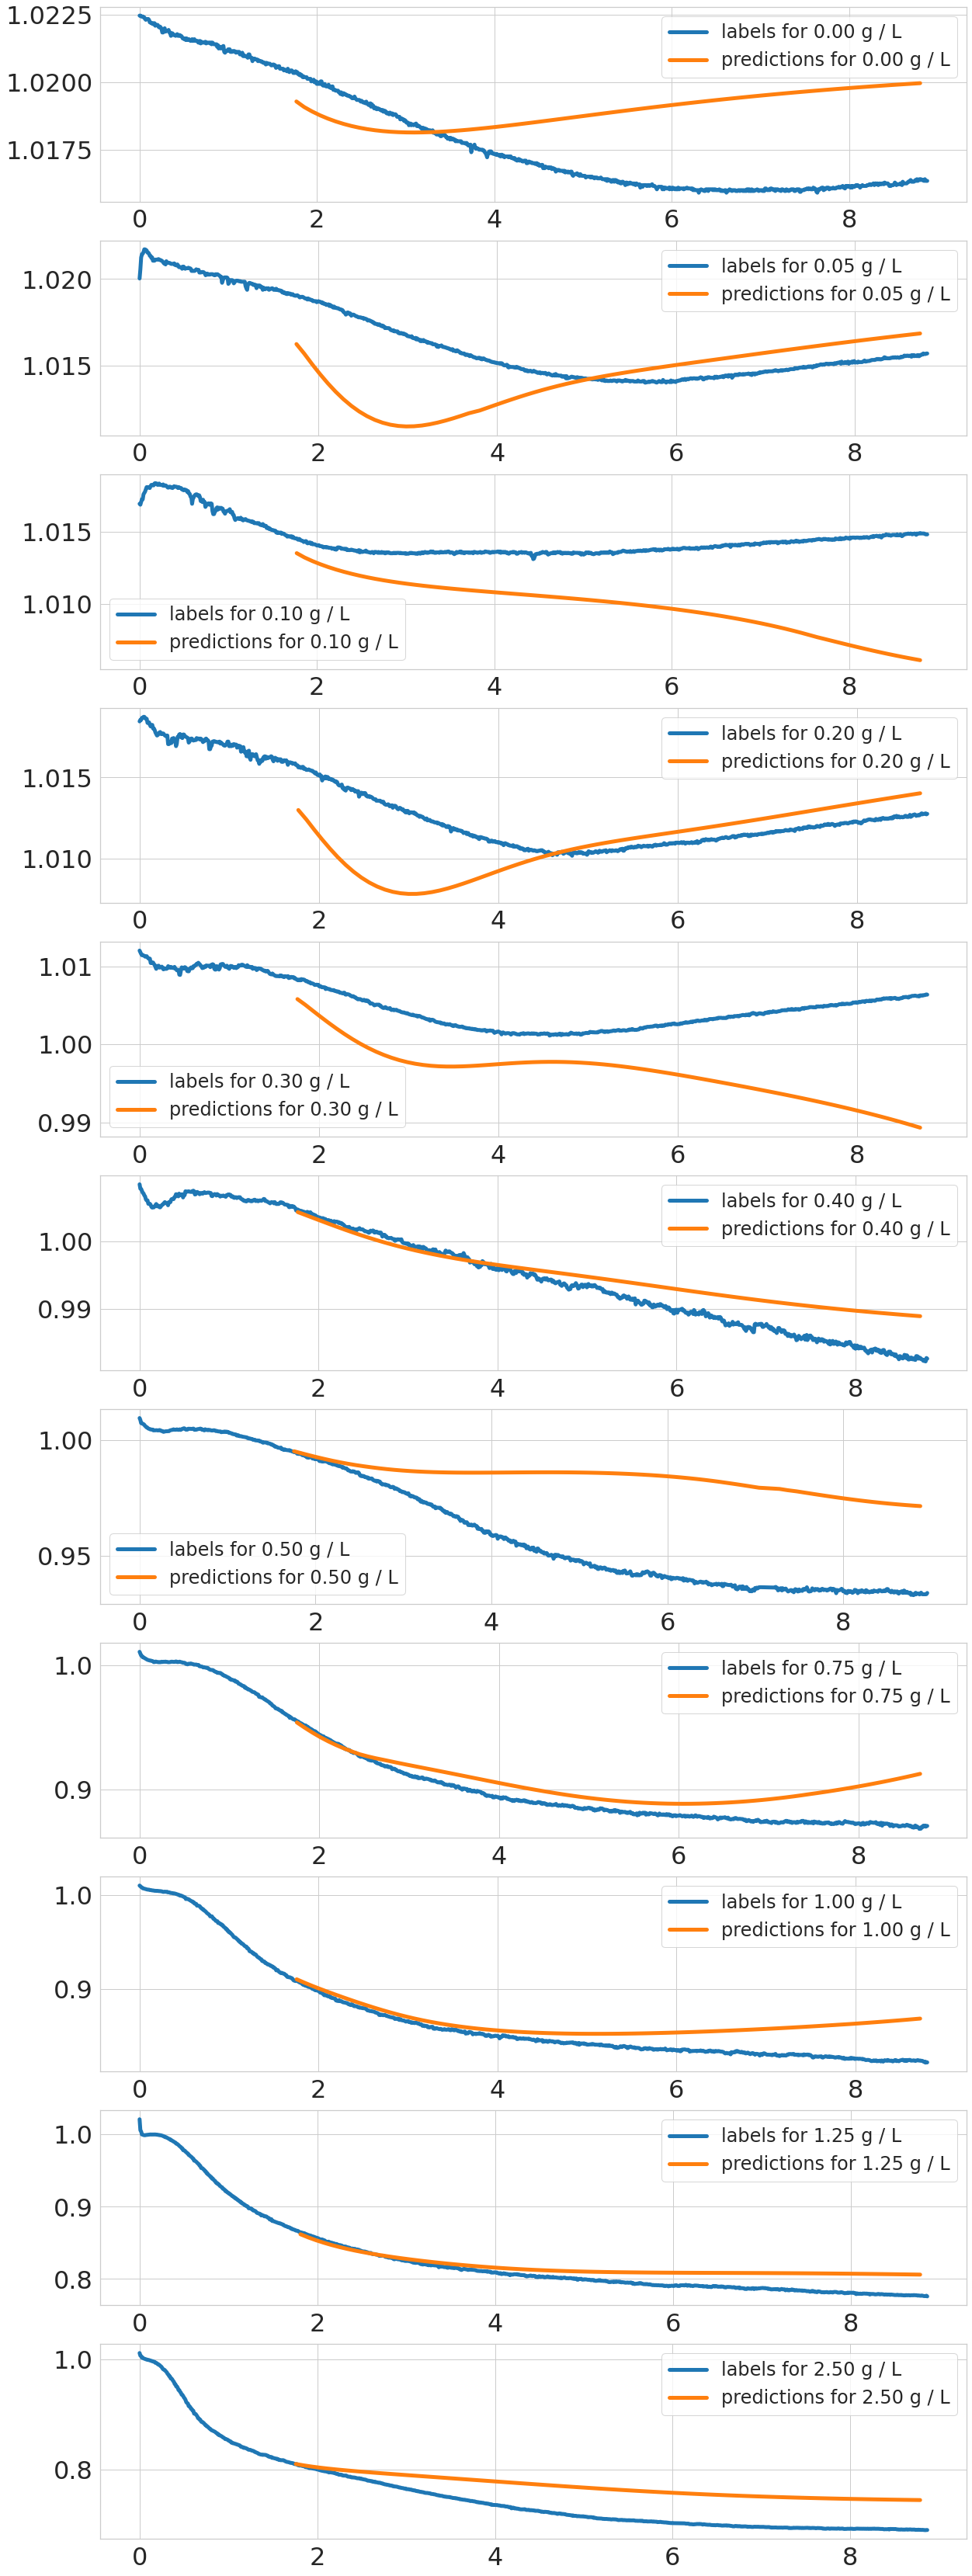

In [27]:

fig, axes = plt.subplots(len(val_predictions_and_labels), 1, figsize=(20, 60))


for ax, (volt_predictions, _, label_series, _, _) in zip(
    axes.flatten(),
    sorted(val_predictions_and_labels, key=lambda one: one[2].real_concentration)
):
    ax.plot(
        label_series.points_in_time,
        label_series.voltages,
        label='labels for %4.2f g / L' % label_series.real_concentration,
    )
    ax.plot(
        label_series.points_in_time[200::CLUSTER_LENGTH],
        volt_predictions[0, :],
        label='predictions for %4.2f g / L' % label_series.real_concentration,
    )
    ax.legend()





/home/christoph/.virtualenvs/glucose-ts/lib/python3.8/site-packages/numpy/ma/core.py:2831: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _data = np.array(data, dtype=dtype, copy=copy,


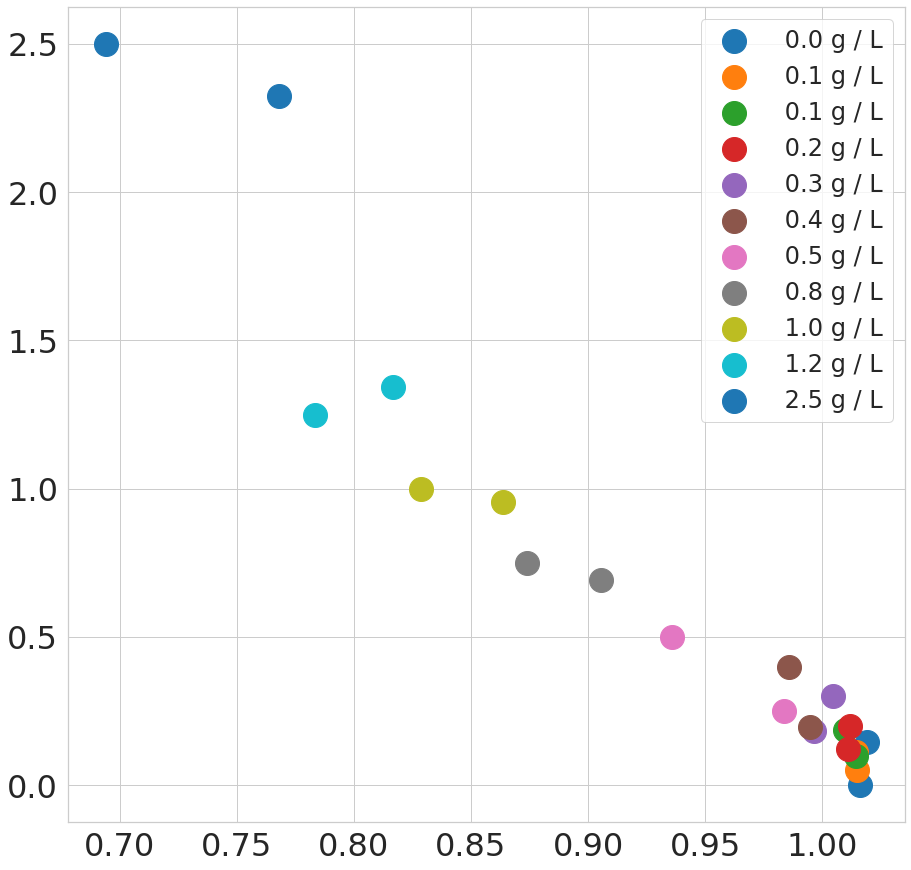

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

results = [
    (
        np.mean(volt_predictions[0, -300:]),
        glucose_prediction,
        np.mean(real_series.voltages[-300:]),
        real_series.real_concentration
    )   
    for volt_predictions, glucose_prediction, real_series, _, _ in sorted(
        val_predictions_and_labels,
        key=lambda one: one[2].real_concentration
    )
]


for final_volt_prediction, glc_prediction, final_voltage, real_concentration in results:
    ax.scatter(
        [final_volt_prediction, final_voltage],
        [glc_prediction, real_concentration],
        label=('%4.1f g / L' % real_concentration)

    )

ax.legend()

In [29]:
glucose_values

[(0, 0.19894245266914368),
 (0.05, 0.20276883244514465),
 (0.1, 0.1354341357946396),
 (0.2, 0.11428389698266983),
 (0.3, 0.17363977432250977),
 (0.4, 0.17750993371009827),
 (0.5, 0.3141239583492279),
 (0.75, 0.7350994944572449),
 (1.0, 0.940321683883667),
 (1.25, 1.447346568107605),
 (2.5, 2.728754997253418)]

In [31]:
from sklearn import metrics

glucose_cut_off = 0.8

voltage_values = [
    (final_voltage, final_volt_prediction)
    for final_volt_prediction, glc_prediction, final_voltage, real_concentration in results
]

glucose_values = [
    (real_concentration, float(glc_prediction))
    for final_volt_prediction, glc_prediction, final_voltage, real_concentration in results
    if glc_prediction < 100
]

glucose_below_2_5 = [
    (real_concentration, float(glc_prediction))
    for final_volt_prediction, glc_prediction, final_voltage, real_concentration in results
    if real_concentration <= glucose_cut_off
    
]


print('Final Voltages: %s' % glucose_ts.evaluation.both_models.get_performance_kpis((*zip(*voltage_values))))
print('Glucose Values %s' % glucose_ts.evaluation.both_models.get_performance_kpis((*zip(*glucose_values))))
print('Glucose Values <= %4.2f g / L %s' % (glucose_cut_off, glucose_ts.evaluation.both_models.get_performance_kpis((*zip(*glucose_below_2_5)))))

Final Voltages: {'r2_score': 0.9116, 'mae': 0.0225, 'rmse': 0.032, 'num_evaluations': 11}
Glucose Values {'r2_score': 0.9629, 'mae': 0.1193, 'rmse': 0.1351, 'num_evaluations': 11}
Glucose Values <= 0.80 g / L {'r2_score': 0.6489, 'mae': 0.1249, 'rmse': 0.1411, 'num_evaluations': 8}
